# Olympics Results Data Analysis

Using SQLite queries within Python to analyse the gender balance of Olympic Games and the events held within them. This makes use of the pandasql package to run SQL queries on Pandas Dataframes, returning the result as another Dataframe. Visualisations and any further analysis are done within Python using tools such as Matplotlib and Seaborn.

### There are several steps to my analysis:
- Importing the packages required, and the data
- Cleaning the data
- Some exploratory visualisation and analysis
- In depth analysis of gender participation balance

## Importing packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#The package used to run sql queries on dataframes
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
regions = pd.read_csv(r"C:\Users\Jacob\Documents\Data Portfolios\Olympics\noc_regions.csv")
athletes = pd.read_csv(r"C:\Users\Jacob\Documents\Data Portfolios\Olympics\athlete_events.csv")

display(regions.head())
display(athletes.head())

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
#Query which joins the two dataframes. 
#Since the two tables are relatively small, joining them fully in the first instance is most efficient.
#All of the columns are selected at this stage (without duplication).

q_join = """
    SELECT ID, Name, Sex, Age, Height, Weight, Team, Games, Year, Season, City, Sport, Event, Medal, regions.NOC, region as Region, Notes
    FROM athletes
    INNER JOIN regions
    ON athletes.NOC = regions.NOC
"""
df_join = pysqldf(q_join).set_index('ID')

df_join.head()

,Name,Sex,Age,Height,Weight,Team,Games,Year,Season,City,Sport,Event,Medal,NOC,Region,notes
ID,,,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,CHN,China,None
2,A Lamusi,M,23.0,170.0,60.0,China,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,CHN,China,None
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,DEN,Denmark,None
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,DEN,Denmark,None
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,NED,Netherlands,None


## Cleaning: removing columns/records

I can drop any rows and columns which won't be used for the analysis. This might include any duplicated information.
- The NOC, Region and Team all provide information on where the athlete is from or who they represent. Choose to keep the Region for this, instead of the Team. The Team matches the Region in the recent games, with lots of random Team names from the earliest editions.
- Can drop the Notes column, which is not used for the analysis.
- There is duplicated information across the Games, Year and Season columns. I could drop the Games column to prevent such duplication. I have chosen not to because it allows for the athletes to be grouped by the Games later. This is necessary (instead of grouping by Year) because Winter and Summer games weren't staggered to begin with.


There are some sports which no longer appear in the Games. I have created a query that returns the last year in which a sport appears. There are 15 sports which are removed, which do not appear after 1950.

In [4]:
#Dropping the team and notes columns
q_col_drop = """
    SELECT ID, Name, Sex, Age, Height, Weight, Games, Year, Season, City, Sport, Event, Medal, NOC, Region
    FROM df_join
"""

df_col_drop = pysqldf(q_col_drop).set_index('ID')

In [5]:
#Query to identify the sports no longer competed in, and the year of their last inclusion.
q_last_inclusion = """
    SELECT Sport, MAX(Year) as Last_Inclusion
    FROM df_col_drop
    GROUP BY Sport
    HAVING Last_Inclusion < 2000
    ORDER BY Last_Inclusion
"""

df_last_inclusion = pysqldf(q_last_inclusion)
display(df_last_inclusion)


#Query to remove rows corresponding to the 15 old sports.
q_drop_sports = """
    SELECT *
    FROM df_col_drop
    WHERE Sport NOT IN ('Aeronautics', 'Alpinism', 'Art Competitions', 'Basque Pelota', 'Cricket', 'Croquet', 'Jeu De Paume', 'Lacrosse', 'Military Ski Patrol', 'Motorboating','Polo', 'Racquets', 'Roque', 'Rugby', 'Tug-Of-War')
"""

df_row_drop = pysqldf(q_drop_sports)

,Sport,Last_Inclusion
0,Basque Pelota,1900
1,Cricket,1900
2,Croquet,1900
3,Roque,1904
4,Jeu De Paume,1908
5,Lacrosse,1908
6,Motorboating,1908
7,Racquets,1908
8,Tug-Of-War,1920
9,Military Ski Patrol,1924


## Cleaning: improving data quality
Checking for NULL values, incorrect values and any inconsistencies. This will ensure I can do good analysis on the data and be confident in the results.

Some issues identified regarding NULL values:
 - Missing data in age, height and weight columns. Ignored since my analysis doesn't focus on these columns.
 - NULL values in the medal column just represent the non-medallists.
 - The missing values in the region column will be checked.


In [6]:
df_row_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266563 entries, 0 to 266562
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      266563 non-null  int64  
 1   Name    266563 non-null  object 
 2   Sex     266563 non-null  object 
 3   Age     257756 non-null  float64
 4   Height  210527 non-null  float64
 5   Weight  207837 non-null  float64
 6   Games   266563 non-null  object 
 7   Year    266563 non-null  int64  
 8   Season  266563 non-null  object 
 9   City    266563 non-null  object 
 10  Sport   266563 non-null  object 
 11  Event   266563 non-null  object 
 12  Medal   39119 non-null   object 
 13  NOC     266563 non-null  object 
 14  Region  266544 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 30.5+ MB


In [7]:
#Filling missing values in the region column.

display(regions[regions['region'].isnull()]) #NOCs with no region associated.

df_row_drop.loc[df_row_drop['NOC'] == 'TUV', ['Region']] = 'Tuvalu'
df_row_drop.loc[df_row_drop['NOC'] == 'ROT', ['Region']] = 'Refugee Olympic Team'
#Note that the 'UNK' NOC records were removed due to the competitors participating in obselete sports.

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [8]:
#Replacing NULLs with a string to make the equality in medal awards possible.
df_row_drop['Medal'].fillna('None', inplace=True)

In [48]:
#Dataframe to be taken forward for analysis.
df_eda = df_row_drop.copy()
df_eda.head()

,ID,Name,Sex,Age,Height,Weight,Games,Year,Season,City,Sport,Event,Medal,NOC,Region
0,1,A Dijiang,M,24.0,180.0,80.0,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,CHN,China
1,2,A Lamusi,M,23.0,170.0,60.0,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,CHN,China
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,DEN,Denmark
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,NED,Netherlands
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",None,NED,Netherlands


# Exploratory Visualisations
Investigating each of the variables to identify the distributions of competitor characteristics. This helped to point my investigation of the Olympics data towards gender equality. The findings are as follows:
 - More than 2.5 times more men have competed than women.
 - Age, height and weight are all close to normally distributed.
 - The weight column could be cleaner - sometimes decimal values have been recorded.
 - Participation much higher in the summer games, but rising in both summer and winter.
 - Not equal numbers of gold, silver and bronze medals. Are some medals shared?

In [10]:
q_sex_check = """
    SELECT Sex, COUNT(*) as Count
    FROM df_eda
    GROUP BY Sex
"""

df_sex = pysqldf(q_sex_check)
df_sex

,Sex,Count
0,F,74008
1,M,192555


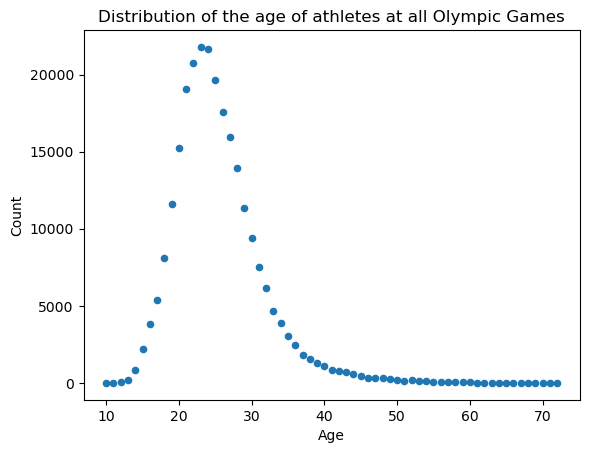

In [11]:
q_age_check = """
    SELECT Age, COUNT(*) as Count
    FROM df_eda
    GROUP BY Age
"""

df_age = pysqldf(q_age_check)

df_age[df_age['Age']!='NA'].plot(kind='scatter', x='Age', y='Count')
plt.title('Distribution of the age of athletes at all Olympic Games');

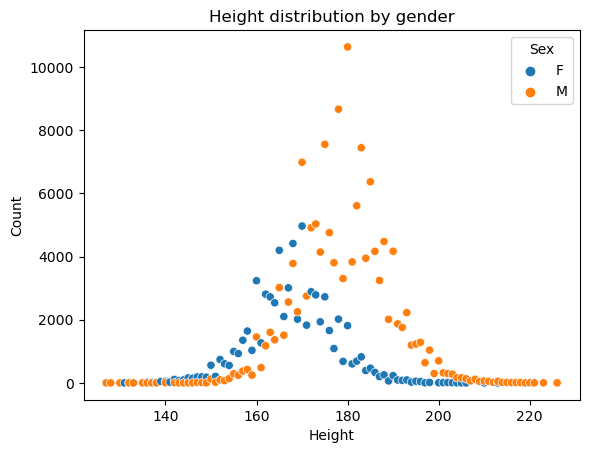

In [12]:
q_height_gender = """
    SELECT Height, Sex, COUNT(*) as Count
    FROM df_eda
    GROUP BY Height, Sex
"""


df_height_gender = pysqldf(q_height_gender)

sns.scatterplot(data=df_height_gender[df_height_gender['Height']!='NA'], x='Height', y='Count', hue='Sex')
plt.title('Height distribution by gender');

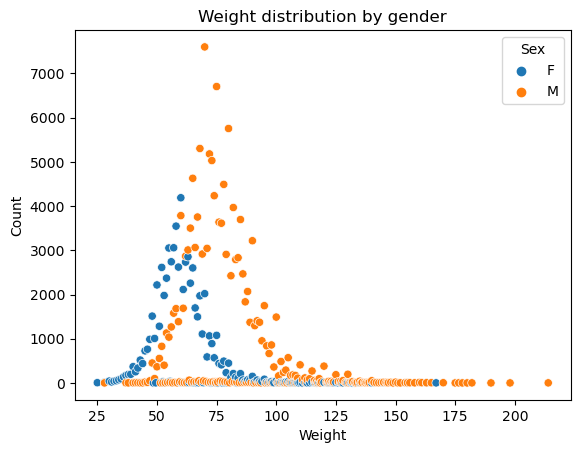

In [13]:
q_weight_gender = """
    SELECT Weight, Sex, COUNT(*) as Count
    FROM df_eda
    GROUP BY Weight, Sex
"""

df_weight_gender = pysqldf(q_weight_gender)

sns.scatterplot(data=df_weight_gender[df_weight_gender['Weight']!='NA'], x='Weight', y='Count', hue='Sex') #Not enough data to be normal?
plt.title('Weight distribution by gender');

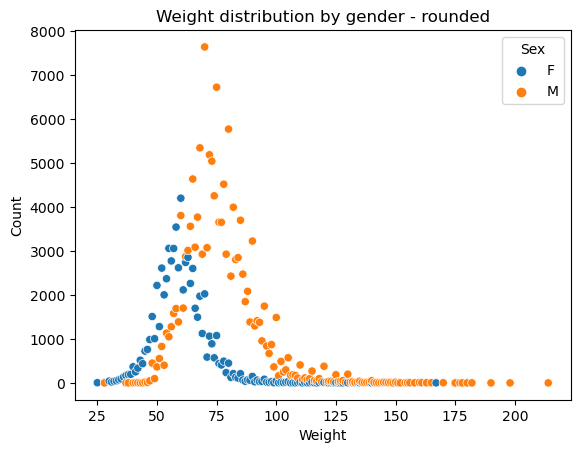

In [14]:
q_weight_correct = """
    SELECT Weight, Sex, COUNT(*) as Count
    FROM (
        SELECT Sex, ROUND(Weight) as Weight
        FROM df_eda
    )
    GROUP BY Weight, Sex
"""

df_weight_correct = pysqldf(q_weight_correct)

sns.scatterplot(data=df_weight_correct[df_weight_correct['Weight']!='NA'], x='Weight', y='Count', hue='Sex')
plt.title('Weight distribution by gender - rounded');

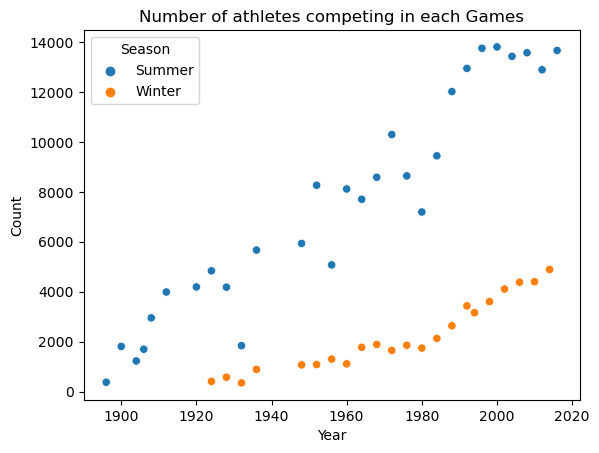

In [15]:
q_year_split = """
    SELECT Year, Season, COUNT(*) as Count
    FROM df_eda
    GROUP BY Year, Season
    --ORDER BY Count DESC
"""

df_year_split = pysqldf(q_year_split)

sns.scatterplot(data=df_year_split, x='Year', y='Count', hue='Season')
plt.title('Number of athletes competing in each Games');

In [16]:
q_medal_check = """
    SELECT Medal, COUNT(*) as Count
    FROM df_eda
    GROUP BY Medal
    --ORDER BY Count DESC
"""

df_medal_check = pysqldf(q_medal_check)

display(df_medal_check)

,Medal,Count
0,Bronze,13151
1,Gold,13106
2,None,227444
3,Silver,12862


# Plan for further investigation: Gender equality

The exploratory visualisations revealed that women have been under-represented at every Olympics Games, both winter and summer. While the gender balance has been improving, there is still a way to go to achieve equality. I will investigate in more detail the evolution and sources of the gender imbalance at the Olympics.

- How has male/female participation as a whole changed over time?
- What are the sports and events with best/worst gender equality?
- Are there any obvious areas for improved participation?

# Equality at the Summer and Winter Games

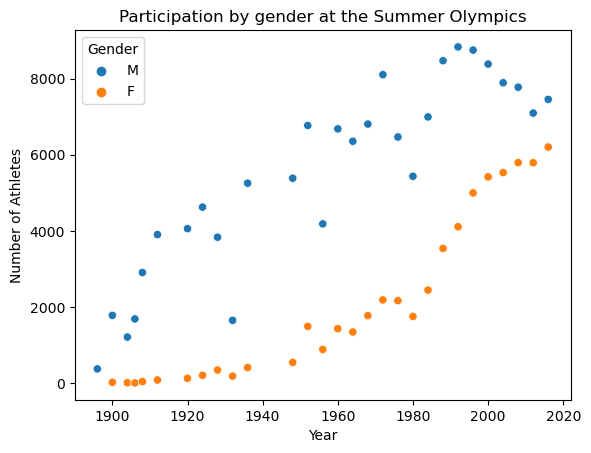

In [17]:
q_summer_equality = """
    SELECT Year, Sex, COUNT(*) as Num_Athletes
    FROM df_eda
    WHERE Season = 'Summer'
    GROUP BY Year, Sex
"""

df_summer_equality = pysqldf(q_summer_equality)

sns.scatterplot(data=df_summer_equality, x='Year', y='Num_Athletes', hue='Sex')
plt.title('Participation by gender at the Summer Olympics')
plt.ylabel('Number of Athletes')
plt.legend(title='Gender');

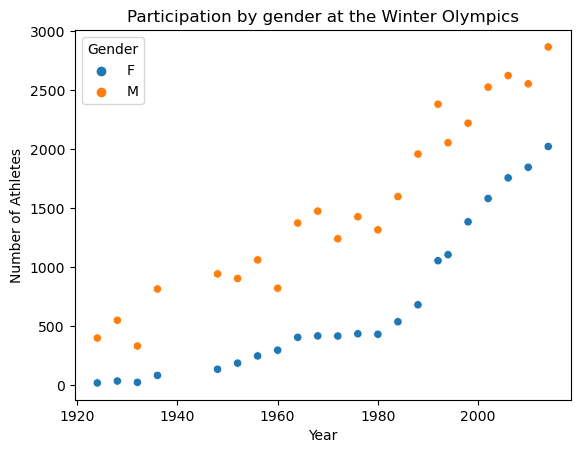

In [18]:
q_winter_equality = """
    SELECT Year, Sex, COUNT(*) as Num_Athletes
    FROM df_eda
    WHERE Season = 'Winter'
    GROUP BY Year, Sex
"""

df_winter_equality = pysqldf(q_winter_equality)

sns.scatterplot(data=df_winter_equality, x='Year', y='Num_Athletes', hue='Sex')
plt.title('Participation by gender at the Winter Olympics')
plt.ylabel('Number of Athletes')
plt.legend(title='Gender');

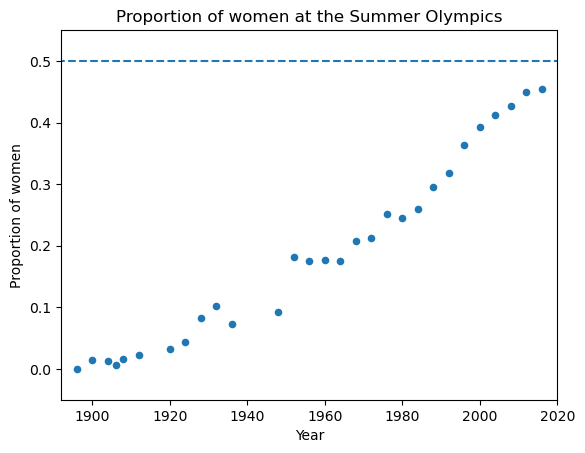

In [19]:
#A query counting the number of men and women participating in each of the Games.
q_sum_equality_ratio = """
    SELECT 
        male.Year      as Year
        , male.Num_M   as Men
        , female.Num_F as Women
    FROM
        (SELECT Year, COUNT(*) as Num_M
        FROM df_eda
        WHERE Season='Summer' AND Sex='M'
        GROUP BY Year) male
    LEFT JOIN
        (SELECT Year, COUNT(*) as Num_F
        FROM df_eda
        WHERE Season='Summer' AND Sex='F'
        GROUP BY Year) female
    ON
        male.year = female.year
"""

df_sum_equality_ratio = pysqldf(q_sum_equality_ratio)

#The calculation of the participation ratio
df_sum_equality_ratio.fillna(0, inplace=True)
df_sum_equality_ratio['Ratio'] = df_sum_equality_ratio['Women']/(df_sum_equality_ratio['Men']+df_sum_equality_ratio['Women'])

x1, y1 = [1888, 2028], [0.5, 0.5]

df_sum_equality_ratio.plot(kind='scatter', x='Year', y='Ratio')
plt.plot(x1, y1, linestyle='dashed') #A line plotted showing the level of equality.
plt.title('Proportion of women at the Summer Olympics')
plt.ylabel('Proportion of women')
plt.ylim(-0.05, 0.55)
plt.xlim(1892, 2020);

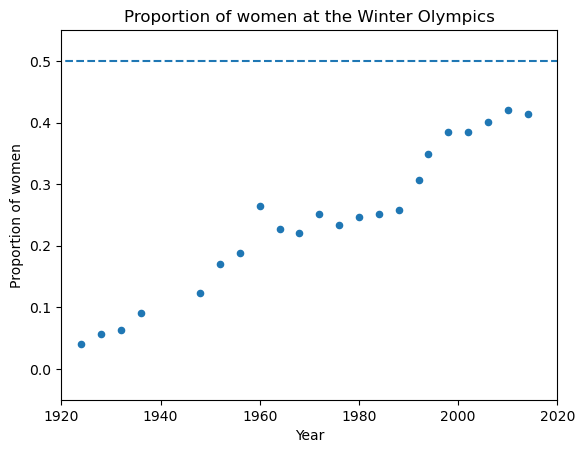

In [20]:
q_win_equality_ratio = """
    SELECT 
        male.Year      as Year
        , male.Num_M   as Men
        , female.Num_F as Women
    FROM
        (SELECT Year, COUNT(*) as Num_M
        FROM df_eda
        WHERE Season='Winter' AND Sex='M'
        GROUP BY Year) male
    LEFT JOIN
        (SELECT Year, COUNT(*) as Num_F
        FROM df_eda
        WHERE Season='Winter' AND Sex='F'
        GROUP BY Year) female
    ON
        male.year = female.year
"""

df_win_equality_ratio = pysqldf(q_win_equality_ratio)

#The calculation of the ratio
df_win_equality_ratio.fillna(0, inplace=True)
df_win_equality_ratio['Ratio'] = df_win_equality_ratio['Women']/(df_win_equality_ratio['Men']+df_win_equality_ratio['Women'])


df_win_equality_ratio.plot(kind='scatter', x='Year', y='Ratio')
plt.plot(x1, y1, linestyle='dashed') #A line plotted showing the level of equality.
plt.title('Proportion of women at the Winter Olympics')
plt.ylabel('Proportion of women')
plt.ylim(-0.05, 0.55)
plt.xlim(1920, 2020);

# Equality within summer sports
Perform calculations of the gender balance of each of the summer and winter sports. The ratio of men to women competing in the sports is calculated for the two most recent Games. A scatterplot showing the two ratios for each sport shows which are the most equal, and those which have the most progress to make.

In [21]:
#Calculation of the number of participants by gender, sport and games.
q_sport_equality_sum_recent = """
    SELECT 
        F_2016.Sport
        , F_2012.F2012
        , M_2012.M2012
        , F_2016.F2016
        , M_2016.M2016
    FROM
        (SELECT Sport, COUNT(*) AS F2016
        FROM df_eda
        WHERE Year='2016' AND Sex='F'
        GROUP BY Sport) F_2016
    LEFT JOIN
        (SELECT Sport, COUNT(*) AS M2012
        FROM df_eda
        WHERE Year='2012' AND Sex='M'
        GROUP BY Sport) M_2012
    ON
        F_2016.Sport = M_2012.Sport
    LEFT JOIN 
        (SELECT Sport, COUNT(*) AS M2016
        FROM df_eda
        WHERE Year='2016' AND Sex='M'
        GROUP BY Sport) M_2016
    ON
        F_2016.Sport = M_2016.Sport
    LEFT JOIN 
        (SELECT Sport, COUNT(*) AS F2012
        FROM df_eda
        WHERE Year='2012' AND Sex='F'
        GROUP BY Sport) F_2012
    ON
        F_2012.Sport = F_2016.Sport
"""

df_sport_equality_sum_recent = pysqldf(q_sport_equality_sum_recent)

In [22]:
#Equality ratios calculated for each sport.
df_sport_equality_sum_recent.fillna(0, inplace=True) #Allows ratios to be calculated where there is no participation.

df_sport_equality_sum_recent['ratio_2012'] = df_sport_equality_sum_recent['F2012']/(df_sport_equality_sum_recent['M2012']+df_sport_equality_sum_recent['F2012'])
df_sport_equality_sum_recent['ratio_2016'] = df_sport_equality_sum_recent['F2016']/(df_sport_equality_sum_recent['M2016']+df_sport_equality_sum_recent['F2016'])

df_sport_equality_sum_recent['ratio_joint'] = (df_sport_equality_sum_recent['F2016']+df_sport_equality_sum_recent['F2012'])/(df_sport_equality_sum_recent['M2016']+df_sport_equality_sum_recent['F2016']+df_sport_equality_sum_recent['M2012']+df_sport_equality_sum_recent['F2012'])

In [23]:
from bokeh.plotting import Figure, output_notebook, show, save
from bokeh.models import ColumnDataSource, HoverTool, GroupFilter, CDSView

output_notebook()

Loading BokehJS ...

In [24]:
data = ColumnDataSource(df_sport_equality_sum_recent)

summer_sports = Figure(tooltips=[('Sport', '@Sport'), ('Gender Ratio', '@ratio_joint')]
                       , width=500, height=500, title='Equality in Summer Sports'
                       , x_axis_label='Proportion of women in the 2012 Games'
                       , y_axis_label='Proportion of women in the 2016 Games'
                      )
summer_sports.scatter(source=data, x='ratio_2012', y='ratio_2016', size=8)

show(summer_sports);

# Equality within winter sports

In [52]:
#Gender breakdown by games and sport
q_sport_equality_wint_recent = """
    SELECT 
        M_2014.Sport
        , F_2014.F2014
        , M_2014.M2014
        , F_2010.F2010
        , M_2010.M2010
    FROM
        (SELECT Sport, COUNT(*) AS M2014
        FROM df_eda
        WHERE Year='2014' AND Sex='M'
        GROUP BY Sport) M_2014
    LEFT JOIN
        (SELECT Sport, COUNT(*) AS F2014
        FROM df_eda
        WHERE Year='2014' AND Sex='F'
        GROUP BY Sport) F_2014
    ON
        F_2014.Sport = M_2014.Sport
    LEFT JOIN 
        (SELECT Sport, COUNT(*) AS M2010
        FROM df_eda
        WHERE Year='2010' AND Sex='M'
        GROUP BY Sport) M_2010
    ON
        M_2014.Sport = M_2010.Sport
    LEFT JOIN 
        (SELECT Sport, COUNT(*) AS F2010
        FROM df_eda
        WHERE Year='2010' AND Sex='F'
        GROUP BY Sport) F_2010
    ON
        M_2014.Sport = F_2010.Sport
"""

df_sport_equality_wint_recent = pysqldf(q_sport_equality_wint_recent)

In [53]:
df_sport_equality_wint_recent.fillna(0, inplace=True)

df_sport_equality_wint_recent['ratio_2014'] = df_sport_equality_wint_recent['F2014']/(df_sport_equality_wint_recent['M2014']+df_sport_equality_wint_recent['F2014'])
df_sport_equality_wint_recent['ratio_2010'] = df_sport_equality_wint_recent['F2010']/(df_sport_equality_wint_recent['M2010']+df_sport_equality_wint_recent['F2010'])

df_sport_equality_wint_recent['ratio_joint'] = (df_sport_equality_wint_recent['F2010']+df_sport_equality_wint_recent['F2014'])/(df_sport_equality_wint_recent['M2010']+df_sport_equality_wint_recent['F2010']+df_sport_equality_wint_recent['M2014']+df_sport_equality_wint_recent['F2014'])

In [54]:
data = ColumnDataSource(df_sport_equality_wint_recent)

winter_sports = Figure(tooltips=[('Sport', '@Sport'), ('Gender Ratio', '@ratio_joint')]
                       , width=500, height=500, title='Equality in Winter Sports'
                       , x_axis_label='Proportion of women in the 2010 Games'
                       , y_axis_label='Proportion of women in the 2014 Games'
                      )
winter_sports.scatter(source=data, x='ratio_2010', y='ratio_2014', size=8)

show(winter_sports);

# Equality in available medals
There are clear differences in the equality of participation in the different sports at the Olympic Games. Does this translate to a different number of medals available for men and women? It could be the case that less women are competing for the same number of medals.

In [57]:
#Query calculating the number of medals available per sport at the 2016 Summer Games.
q_sum2016_sport_medals = """
    SELECT
        F_medals.Sport
        , F_medals.Medal
        , F_medals
        , M_medals
    FROM
        (SELECT Sport, Medal, COUNT(*) as F_Medals
        FROM df_eda
        WHERE Year='2016' AND Sex='F'
        GROUP BY Sport, Medal) F_medals
    LEFT JOIN
        (SELECT Sport, Medal, COUNT(*) as M_Medals
        FROM df_eda
        WHERE Year='2016' AND Sex='M'
        GROUP BY Sport, Medal) M_medals
    ON
        F_medals.Sport=M_medals.Sport
    AND
        F_medals.Medal=M_medals.Medal
"""

df_sum2016_sport_medals = pysqldf(q_sum2016_sport_medals)
df_sum2016_sport_medals.fillna(0, inplace=True)

In [69]:
from bokeh.models.widgets import Tabs, Panel

data_none = ColumnDataSource(df_sum2016_sport_medals[df_sum2016_sport_medals['Medal']=='None'])
none_scatter = Figure(title='Number of non-medallists per summer sport', x_axis_label='Female non-medallists', y_axis_label='Male non-medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
none_scatter.scatter(source=data_none, x='F_Medals', y='M_Medals', size=8)

data_golds = ColumnDataSource(df_sum2016_sport_medals[df_sum2016_sport_medals['Medal']=='Gold'])
golds_scatter = Figure(title='Number of golds per summer sport', x_axis_label='Female gold medallists', y_axis_label='Male gold medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
golds_scatter.scatter(source=data_golds, x='F_Medals', y='M_Medals', size=8)


data_silvers = ColumnDataSource(df_sum2016_sport_medals[df_sum2016_sport_medals['Medal']=='Silver'])
silvers_scatter = Figure(title='Number of silvers per summer sport', x_axis_label='Female silver medallists', y_axis_label='Male silver medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
silvers_scatter.scatter(source=data_silvers, x='F_Medals', y='M_Medals', size=8)

data_bronzes = ColumnDataSource(df_sum2016_sport_medals[df_sum2016_sport_medals['Medal']=='Bronze'])
bronzes_scatter = Figure(title='Number of bronzes per summer sport', x_axis_label='Female bronze medallists', y_axis_label='Male bronze medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
bronzes_scatter.scatter(source=data_bronzes, x='F_Medals', y='M_Medals', size=8)

none_panel = Panel(child=none_scatter, title='Non-Medallists')
gold_panel = Panel(child=golds_scatter, title='Gold Medallists')
silver_panel = Panel(child=silvers_scatter, title='Silver Medallists')
bronze_panel = Panel(child=bronzes_scatter, title='Bronze Medallists')

all_medals = Tabs(tabs=[gold_panel, silver_panel, bronze_panel, none_panel])
show(all_medals)

In [62]:
#Counting number of events per summer sport.
q_sum2016_sport_events = """
    SELECT
        F.Sport
        , F_events
        , M_events
    FROM
        (SELECT Sport, COUNT(DISTINCT(Event)) as F_events
        FROM df_eda
        WHERE Year='2016' AND Sex='F'
        GROUP BY Sport) F
    LEFT JOIN
        (SELECT Sport, COUNT(DISTINCT(Event)) as M_events
        FROM df_eda
        WHERE Year='2016' AND Sex='M'
        GROUP BY Sport) M
    ON
        F.Sport=M.Sport
"""

df_sum2016_sport_events = pysqldf(q_sum2016_sport_events)

df_sum2016_sport_events.fillna(0, inplace=True)

In [63]:
data = ColumnDataSource(df_sum2016_sport_events)

events_scatter = Figure(title='Number of events per summer sport', x_axis_label='Events for women', y_axis_label='Events for men',tooltips=[('Sport', '@Sport')], width=500, height=300)
events_scatter.scatter(source=data, x='F_events', y='M_events', size=8)

show(events_scatter)

In [66]:
q_wint2014_sport_medals = """
    SELECT
        F_medals.Sport
        , F_medals.Medal
        , F_medals
        , M_medals
    FROM
        (SELECT Sport, Medal, COUNT(*) as F_Medals
        FROM df_eda
        WHERE Year='2014' AND Sex='F'
        GROUP BY Sport, Medal) F_medals
    LEFT JOIN
        (SELECT Sport, Medal, COUNT(*) as M_Medals
        FROM df_eda
        WHERE Year='2014' AND Sex='M'
        GROUP BY Sport, Medal) M_medals
    ON
        F_medals.Sport=M_medals.Sport
    AND
        F_medals.Medal=M_medals.Medal
"""

df_wint2014_sport_medals = pysqldf(q_wint2014_sport_medals)

df_wint2014_sport_medals.fillna(0, inplace=True)

In [68]:
data_none = ColumnDataSource(df_wint2014_sport_medals[df_wint2014_sport_medals['Medal']=='None'])
none_scatter = Figure(title='Number of non-medallists per winter sport', x_axis_label='Female non-medallists', y_axis_label='Male non-medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
none_scatter.scatter(source=data_none, x='F_Medals', y='M_Medals', size=8)

data_golds = ColumnDataSource(df_wint2014_sport_medals[df_wint2014_sport_medals['Medal']=='Gold'])
golds_scatter = Figure(title='Number of gold medallists per winter sport', x_axis_label='Female gold medallists', y_axis_label='Male gold medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
golds_scatter.scatter(source=data_golds, x='F_Medals', y='M_Medals', size=8)

data_silvers = ColumnDataSource(df_wint2014_sport_medals[df_wint2014_sport_medals['Medal']=='Silver'])
silvers_scatter = Figure(title='Number of silver medallists per winter sport', x_axis_label='Female silver medallists', y_axis_label='Male silver medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
silvers_scatter.scatter(source=data_silvers, x='F_Medals', y='M_Medals', size=8)

data_bronzes = ColumnDataSource(df_wint2014_sport_medals[df_wint2014_sport_medals['Medal']=='Bronze'])
bronzes_scatter = Figure(title='Number of bronze medallists per winter sport', x_axis_label='Female bronze medallists', y_axis_label='Male bronze medallists', tooltips=[('Sport', '@Sport')], width=500, height=300)
bronzes_scatter.scatter(source=data_bronzes, x='F_Medals', y='M_Medals', size=8)

none_panel = Panel(child=none_scatter, title='Non-Medallists')
gold_panel = Panel(child=golds_scatter, title='Gold Medallists')
silver_panel = Panel(child=silvers_scatter, title='Silver Medallists')
bronze_panel = Panel(child=bronzes_scatter, title='Bronze Medallists')

all_medals = Tabs(tabs=[gold_panel, silver_panel, bronze_panel, none_panel])
show(all_medals)

In [71]:
q_wint2014_sport_events = """
    SELECT
        M.Sport
        , F_events
        , M_events
    FROM
        (SELECT Sport, COUNT(DISTINCT(Event)) as M_events
        FROM df_eda
        WHERE Year='2014' AND Sex='M'
        GROUP BY Sport) M
    LEFT JOIN
        (SELECT Sport, COUNT(DISTINCT(Event)) as F_events
        FROM df_eda
        WHERE Year='2014' AND Sex='F'
        GROUP BY Sport) F
    ON
        F.Sport=M.Sport

"""

df_wint2014_sport_events = pysqldf(q_wint2014_sport_events)

df_wint2014_sport_events.fillna(0, inplace=True)

In [72]:
data = ColumnDataSource(df_wint2014_sport_events)

events_scatter = Figure(title='Number of events per winter sport', x_axis_label='Events for women', y_axis_label='Events for men',tooltips=[('Sport', '@Sport')], width=500, height=300)
events_scatter.scatter(source=data, x='F_events', y='M_events', size=8)

show(events_scatter)

# Does gender balance (or otherwise) lead to success?
Might the nations with greater equality in their teams be more successful?

In [39]:
#Creating a total medal table can act as the basis for a measure of success.
q_total_medal_table = """
    SELECT
        regions.Region
        , gold.Golds
        , silver.Silvers
        , bronze.Bronzes
    FROM
        (SELECT DISTINCT(Region) as Region
        FROM df_eda) regions
    LEFT JOIN
        (SELECT Region, COUNT(*) as Golds
        FROM df_eda
        WHERE Medal = 'Gold'
        GROUP BY Region) gold
    ON 
        regions.Region = gold.Region
    LEFT JOIN
        (SELECT Region, COUNT(*) as Silvers
        FROM df_eda
        WHERE Medal = 'Silver'
        GROUP BY Region) silver
    ON
        regions.Region = silver.Region
    LEFT JOIN
        (SELECT Region, COUNT(*) as Bronzes
        FROM df_eda
        WHERE Medal = 'Bronze'
        GROUP BY Region) bronze
    ON
        regions.Region = bronze.Region
    ORDER BY Golds DESC    
    
"""

df_table = pysqldf(q_total_medal_table)
df_table

,Region,Golds,Silvers,Bronzes
0,USA,2589.0,1613.0,1348.0
1,Russia,1599.0,1170.0,1178.0
2,Germany,1282.0,1172.0,1250.0
3,UK,615.0,649.0,632.0
4,Italy,570.0,524.0,529.0
...,...,...,...,...
202,Marshall Islands,NaN,NaN,NaN
203,Kiribati,NaN,NaN,NaN
204,Tuvalu,NaN,NaN,NaN
205,South Sudan,NaN,NaN,NaN


In [40]:
#Calculating a gender ratio for every nation for every Games.
q_nation_equality = """
    SELECT 
        games.Games
        , games.Year
        , games.Season
        , regions.Region
        , men.Men
        , women.Women
        , medals.Medals
    FROM
        (SELECT DISTINCT(Games), Year, Season
        FROM df_eda) games
    CROSS JOIN
        (SELECT DISTINCT(Region)
        FROM df_eda) regions
        
    LEFT JOIN
        (SELECT Games, Region, COUNT(*) as Men
        FROM df_eda
        WHERE Sex = 'M'
        GROUP BY Games, Region) men
    ON
        games.Games = men.Games
    AND
        regions.Region = men.Region
        
    LEFT JOIN
        (SELECT Games, Region, COUNT(*) as Women
        FROM df_eda
        WHERE Sex = 'F'
        GROUP BY Games, Region) women
    ON
        games.Games = women.Games
    AND
        regions.Region = women.Region
        
    LEFT JOIN
        (SELECT Games, Region, COUNT(*) as Medals
        FROM df_eda
        WHERE Medal IN ('Gold', 'Silver', 'Bronze')
        GROUP BY Games, Region) medals
    ON
        games.Games = medals.Games
    AND
        regions.Region = medals.Region
        
"""

df_nation_equality = pysqldf(q_nation_equality)

df_nation_equality_calc = df_nation_equality.copy()

df_nation_equality_calc.dropna(thresh=3, inplace=True) #Removes rows where a nation has no participation in a Games.
df_nation_equality_calc.fillna(0, inplace=True)
df_nation_equality_calc['Gender_Ratio'] = df_nation_equality_calc['Men']/(df_nation_equality_calc['Men']+df_nation_equality_calc['Women'])
df_nation_equality_calc['Medals_Per_Athlete'] = df_nation_equality_calc['Medals']/(df_nation_equality_calc['Men']+df_nation_equality_calc['Women'])


df_nation_equality_calc.select_dtypes('number').corr() #Doesn't show strong relationships.

#Gender ratio has almost no impact on number of medals won by countries.
#Number of men and women both have strong positive correlation with number of medals won.
#The year has the strongest correlation with the gender ratio.

,Year,Men,Women,Medals,Gender_Ratio,Medals_Per_Athlete
Year,1.000000,0.103457,0.219233,0.067269,-0.545817,-0.309498
Men,0.103457,1.000000,0.758255,0.828272,-0.034266,0.392818
Women,0.219233,0.758255,1.000000,0.754907,-0.322198,0.308470
Medals,0.067269,0.828272,0.754907,1.000000,-0.095095,0.513160
Gender_Ratio,-0.545817,-0.034266,-0.322198,-0.095095,1.000000,0.023717
Medals_Per_Athlete,-0.309498,0.392818,0.308470,0.513160,0.023717,1.000000


In [74]:
#Grouping all of the Games together to produce an overall picture for each nation.
q_grouped_equality = """
    SELECT 
        Region
        , SUM(Men) as Men
        , SUM(Women) as Women
        , SUM(Medals) as Medals
    FROM 
        df_nation_equality_calc
    WHERE Season = 'Winter'
    GROUP BY Region
    ORDER BY Medals DESC
"""

df_grouped_equality = pysqldf(q_grouped_equality)

df_grouped_equality['Gender_Ratio'] = df_grouped_equality['Men']/(df_grouped_equality['Men']+df_grouped_equality['Women'])
df_grouped_equality['Medals_Per_Athlete'] = df_grouped_equality['Medals']/(df_grouped_equality['Men']+df_grouped_equality['Women'])

df_grouped_equality.select_dtypes('number').corr()

,Men,Women,Medals,Gender_Ratio,Medals_Per_Athlete
Men,1.000000,0.967456,0.892093,-0.157512,0.839309
Women,0.967456,1.000000,0.911010,-0.214964,0.847113
Medals,0.892093,0.911010,1.000000,-0.133890,0.914881
Gender_Ratio,-0.157512,-0.214964,-0.133890,1.000000,-0.177438
Medals_Per_Athlete,0.839309,0.847113,0.914881,-0.177438,1.000000
